In [321]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split

# Load MovieLens dataset
def load_movielens_data():
    df = pd.read_csv('/home/korisnik/Desktop/AIS-MovieRecomenderSystem/Data/ml-1m/ratings.csv', sep=':')
    
    # Clean column names by stripping leading/trailing whitespace
    df.columns = df.columns.str.strip()
    
    # Print column names to verify
    print("Columns in the DataFrame:", df.columns)
    
    # Pivot the DataFrame, replace 'userId' with the correct column name if necessary
    df = df.pivot(index='userId', columns='movieId', values='ratings').fillna(0)
    df_sample = df.sample(frac=0.1)
    
    return df_sample

In [322]:
# Calculate affinity (similarity) between antibodies and antigens
def calculate_affinity(user_profiles, user_ratings):
    return cosine_similarity(user_profiles, user_ratings)

In [323]:
def gaussian_noise_mutation(clones, mean=0, std=0.1):
    noise = np.random.normal(mean, std, clones.shape)
    mutated_clones = clones + noise
    return np.clip(mutated_clones, 0, 1)

def adaptive_mutation(clones, affinities, base_mutation_rate=0.1, scaling_factor=0.5):
    # Higher mutation for lower affinity
    mutation_rate = base_mutation_rate * (1 - scaling_factor * affinities)
    noise = np.random.normal(0, mutation_rate[:, np.newaxis], clones.shape)
    mutated_clones = clones + noise
    return np.clip(mutated_clones, 0, 1)

def crossover_mutation(clones, crossover_rate=0.5):
    num_clones = clones.shape[0]
    for i in range(0, num_clones, 2):
        if np.random.rand() < crossover_rate:
            # Select a crossover point
            crossover_point = np.random.randint(1, clones.shape[1])
            # Swap segments between two clones
            clones[i, crossover_point:], clones[i+1, crossover_point:] = clones[i+1, crossover_point:], clones[i, crossover_point:]
    return clones

def differential_mutation(clones, mutation_factor=0.8):
    num_clones = clones.shape[0]
    for i in range(num_clones):
        indices = np.random.choice(num_clones, 3, replace=False)
        diff = mutation_factor * (clones[indices[1]] - clones[indices[2]])
        clones[i] = np.clip(clones[indices[0]] + diff, 0, 1)
    return clones

def simulated_annealing_mutation(clones, initial_temp=1.0, cooling_rate=0.99, iteration=1):
    temp = initial_temp * (cooling_rate ** iteration)
    noise = np.random.normal(0, temp, clones.shape)
    mutated_clones = clones + noise
    return np.clip(mutated_clones, 0, 1)

def elite_mutation(clones, affinities, elite_fraction=0.1):
    elite_size = int(elite_fraction * len(clones))
    elite_indices = np.argsort(affinities)[-elite_size:]
    mutated_clones = np.copy(clones)
    
    # Apply mutation to non-elite clones
    non_elite_indices = np.setdiff1d(np.arange(len(clones)), elite_indices)
    mutated_clones[non_elite_indices] = gaussian_noise_mutation(clones[non_elite_indices])
    
    return mutated_clones

In [324]:
def clonal_selection_and_advanced_mutation(affinity, user_profiles, iteration, mutation_rate=0.1):
    best_indices = np.argsort(affinity.sum(axis=1))[-int(len(user_profiles) * 0.1):]
    best_profiles = user_profiles[best_indices]
    
    clones = np.repeat(best_profiles, repeats=5, axis=0)
    
    # Apply advanced mutations
    #clones = gaussian_noise_mutation(clones)
    #clones = adaptive_mutation(clones, affinity)
    #clones = crossover_mutation(clones)
    #clones = differential_mutation(clones)
    #clones = simulated_annealing_mutation(clones, iteration=iteration)
    clones = elite_mutation(clones, affinity)
    
    return clones

In [325]:
def clonal_selection_and_mutation(affinity, user_profiles, mutation_rate=0.1):
    # Select best-performing antibodies
    best_indices = np.argsort(affinity.sum(axis=1))[-int(len(user_profiles) * 0.1):]
    best_profiles = user_profiles[best_indices]
    
    # Clone and mutate
    clones = np.repeat(best_profiles, repeats=5, axis=0)
    mutation = np.random.normal(0, mutation_rate, clones.shape)
    clones = clones + mutation
    
    return clones

In [326]:
# AIS-based recommender system
def ais_recommender_system(data, num_generations = 10, mutation_rate = 0.2):
    user_profiles = np.random.rand(data.shape[0], data.shape[1])  # Initialize antibodies
    
    for _ in range(num_generations):
        affinity = calculate_affinity(user_profiles, data)
        user_profiles = clonal_selection_and_mutation(affinity, user_profiles, mutation_rate)
        
        # Convergence check (optional): if no improvement, stop early
    
    # Generate recommendations based on final user_profiles
    recommendations = np.dot(user_profiles, data.T)
    
    return recommendations

In [327]:
# Predict ratings for unevaluated movies for a fresh user
def predict_ratings_for_unevaluated(user_profile, data, known_ratings_indices):
    # Calculate similarity between the new user profile and all item profiles
    item_similarity = cosine_similarity([user_profile], data)[0]
    
    # Predict ratings for all items
    predicted_ratings = np.dot(item_similarity, data) / np.sum(np.abs(item_similarity))
    
    # Mask the items that the user has already rated
    #predicted_ratings[known_ratings_indices] = -np.inf  # Set known ratings to -inf to exclude them
    
    return predicted_ratings

In [328]:
# Evaluate the recommender system on the test population
def evaluate_recommender_system(test_data, train_data):
    mse_scores = []
    
    for user_id in range(test_data.shape[0]):
        user_profile = test_data.iloc[user_id].values
        known_ratings_indices = np.where(user_profile > 0)[0]
        
        # If the user has some ratings in the test set, predict ratings for the rest
        if len(known_ratings_indices) > 0:
            predicted_ratings = predict_ratings_for_unevaluated(user_profile, train_data, known_ratings_indices)
            
            # Only evaluate the predicted ratings for the movies that were actually rated in the test set
            true_ratings = user_profile[user_profile > 0]
            predicted_ratings_filtered = predicted_ratings[user_profile > 0]
            
            # Calculate MSE for this user
            mse = mean_squared_error(true_ratings, predicted_ratings_filtered)
            mse_scores.append(mse)
    
    # Return the average MSE over all users in the test set
    return np.mean(mse_scores)

In [329]:
# Compute Precision@K for a single user
def precision_at_k_evaluations(actual_ratings, predicted_ratings, k):
    # Get indices of the top K predictions
    top_k_indices = np.argsort(predicted_ratings)[-k:][::-1]
    
    # Count how many of these top K items are in the actual liked items
    relevant_items = np.sum(actual_ratings[top_k_indices] > 0)
    
    # Calculate Precision@K
    return relevant_items / k

# Compute Precision@K for a single user
def precision_at_k_selection(actual_ratings, predicted_ratings, k):
    # Get indices of the top K predictions
    top_k_indices = np.argsort(predicted_ratings)[-k:][::-1]
    
    # Count how many of these top K items are in the actual liked items
    relevant_items = np.argsort(actual_ratings)[-k:][::-1]

    relevant_and_recommended = np.intersect1d(top_k_indices, relevant_items)
    precision = len(relevant_and_recommended) / k
    return precision

In [330]:
# Evaluate the recommender system using Precision@K on the test population
def evaluate_precision_at_k(test_data, train_data, k=10, use_selection=True):
    precision_scores = []
    
    for user_id in range(test_data.shape[0]):
        user_profile = test_data.iloc[user_id].values
        known_ratings_indices = np.where(user_profile > 0)[0]
        
        # If the user has some ratings in the test set, predict ratings for the rest
        if len(known_ratings_indices) > 0:
            predicted_ratings = predict_ratings_for_unevaluated(user_profile, train_data, known_ratings_indices)
            
            # Calculate Precision@K for this user
            if use_selection:
                precision_k = precision_at_k_selection(user_profile, predicted_ratings, k)
            else:
                precision_k = precision_at_k_evaluations(user_profile, predicted_ratings, k)
            precision_scores.append(precision_k)
    
    # Return the average Precision@K over all users in the test set
    return np.mean(precision_scores)

In [344]:
# Main function to tie everything together
if __name__ == "__main__":
    # Load and split the data
    data = load_movielens_data()
    train_data, test_data = train_test_split(data, test_size=0.2, random_state=42)
    
    # Train the AIS-based recommender on the training set
    recommendations = ais_recommender_system(train_data, num_generations=10, mutation_rate=0.2)
    
    # Evaluate the recommender system on the test population
    average_mse = evaluate_recommender_system(test_data, train_data)
    print(f"Mean Squared Error on the test population (ratings): {average_mse}")
    
    average_precision_k = evaluate_precision_at_k(test_data, train_data, k=10, use_selection=False)
    print(f"Precision - average evaluation of top-10 recomended movies: {average_precision_k}")

    average_precision_k = evaluate_precision_at_k(test_data, train_data, k=10)
    print(f"Mean Squared Error on the top-10 recomended movies: {average_precision_k}")

Columns in the DataFrame: Index(['userId', 'movieId', 'ratings'], dtype='object')
Mean Squared Error on the test population (ratings): 9.84338664376176
Precision - average evaluation of top-10 recomended movies: 0.6033057851239669
Mean Squared Error on the top-10 recomended movies: 0.10991735537190084


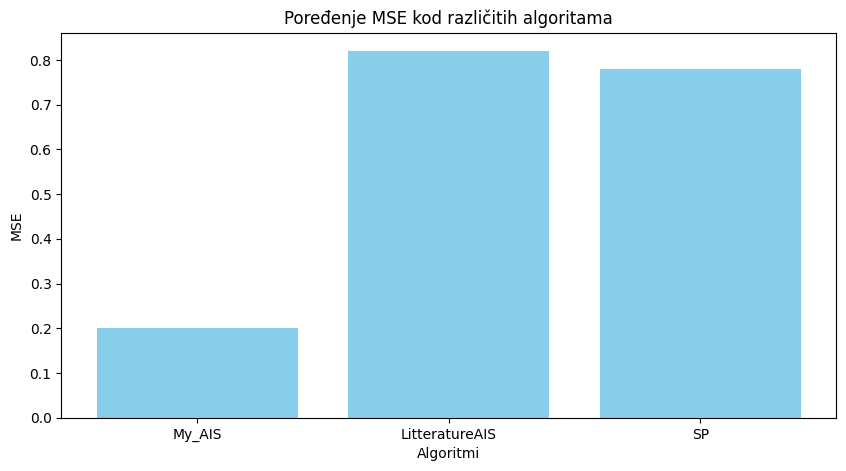

In [332]:
# import matplotlib.pyplot as plt
# # Pokreni eksperiment za AIS algoritam

# #--------------------------------------------------------------------------------- Prvi Eksperiment
# # Uzeto iz literature
# average_mse_littAIS = 0.82 #AIS iz literature
# average_mse_sp = 0.78 #Simple Pearson Predictor

# average_precision_k = 0.2
# # Zameni ove vrednosti u grafikonu
# mse_results = [
#     ('My_AIS', average_precision_k),
#     ('LitteratureAIS', average_mse_littAIS),
#     ('SP', average_mse_sp)
# ]

# # Ekstraktuj algoritme i MSE vrednosti za grafik
# algorithms = [result[0] for result in mse_results]
# mse_values = [result[1] for result in mse_results]

# # Grafik za MSE kod razlicitih algoritama
# plt.figure(figsize=(10, 5))
# plt.bar(algorithms, mse_values, color='skyblue')
# plt.xlabel('Algoritmi')
# plt.ylabel('MSE')
# plt.title('Poređenje MSE kod različitih algoritama')
# plt.show()


Columns in the DataFrame: Index(['userId', 'movieId', 'ratings'], dtype='object')
Columns in the DataFrame: Index(['userId', 'movieId', 'ratings'], dtype='object')
Columns in the DataFrame: Index(['userId', 'movieId', 'ratings'], dtype='object')
Columns in the DataFrame: Index(['userId', 'movieId', 'ratings'], dtype='object')


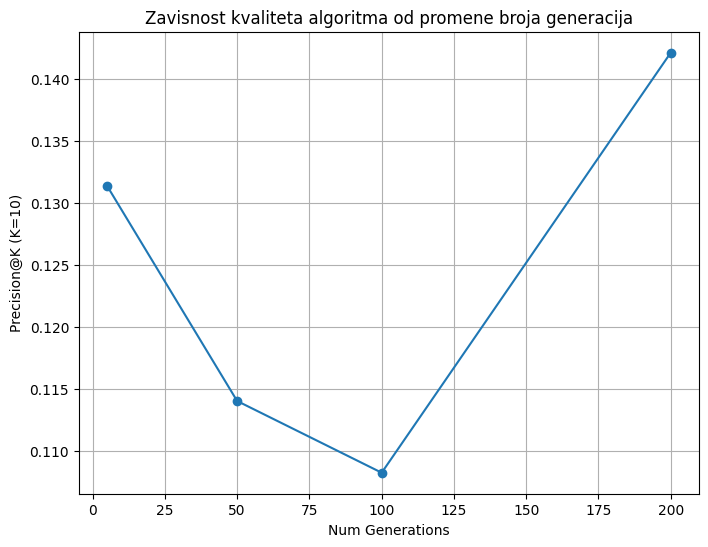

Columns in the DataFrame: Index(['userId', 'movieId', 'ratings'], dtype='object')
Columns in the DataFrame: Index(['userId', 'movieId', 'ratings'], dtype='object')
Columns in the DataFrame: Index(['userId', 'movieId', 'ratings'], dtype='object')
Columns in the DataFrame: Index(['userId', 'movieId', 'ratings'], dtype='object')


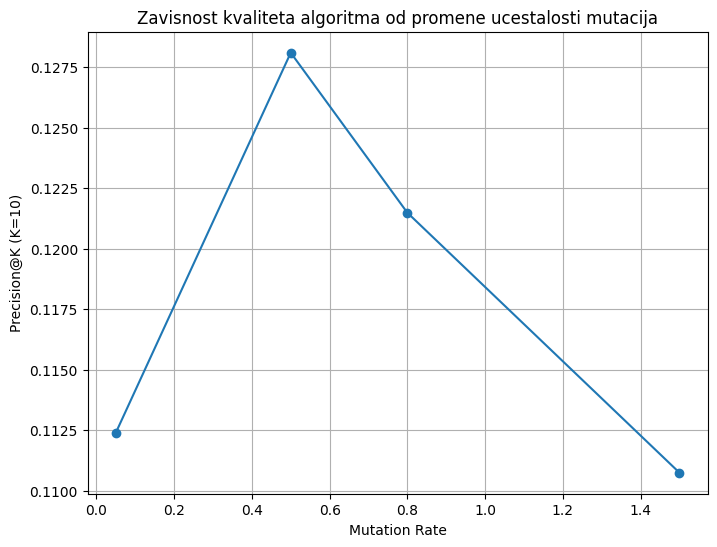

In [333]:
# -------------------------------------------------- Drugi Eksperiment
# Testiramo različite vrednosti hiperparametara
# num_generations_values = [5, 50, 100, 200]
# mutation_rate_values = [0.05, 0.5, 0.8, 1.5]

# def plot_results(x_values, y_values, title, xlabel):
#     plt.figure(figsize=(8, 6))
#     plt.plot(x_values, y_values, marker='o')
#     plt.title(title)
#     plt.xlabel(xlabel)
#     plt.ylabel('Precision@K (K=10)')
#     plt.grid(True)
#     plt.show()
    
# def evaluate_with_hyperparams(train_data, test_data, num_generations, mutation_rate):
#     recommendations = ais_recommender_system(train_data, num_generations=num_generations, mutation_rate=mutation_rate)
#     return evaluate_precision_at_k(test_data, train_data, k=10)

# precision_k_values = []
# for num_gen in num_generations_values:
# # Main function to tie everything together
#     if __name__ == "__main__":
#         # Load and split the data
#         data = load_movielens_data()
#         train_data, test_data = train_test_split(data, test_size=0.2, random_state=42)
#         average_precision_k = evaluate_with_hyperparams(train_data, test_data, num_gen, mutation_rate=0.1)
#         precision_k_values.append(average_precision_k)
        
# plot_results(num_generations_values, precision_k_values, "Zavisnost kvaliteta algoritma od promene broja generacija", "Num Generations")

# precision_k_values = []
# for mut_rate in mutation_rate_values:
# # Main function to tie everything together
#     if __name__ == "__main__":
#         # Load and split the data
#         data = load_movielens_data()
#         train_data, test_data = train_test_split(data, test_size=0.2, random_state=42)
#         num_gen = 10
#         average_precision_k = evaluate_with_hyperparams(train_data, test_data, num_gen, mut_rate)
#         precision_k_values.append(average_precision_k)
        
# plot_results(mutation_rate_values, precision_k_values, "Zavisnost kvaliteta algoritma od promene ucestalosti mutacija", "Mutation Rate")
        


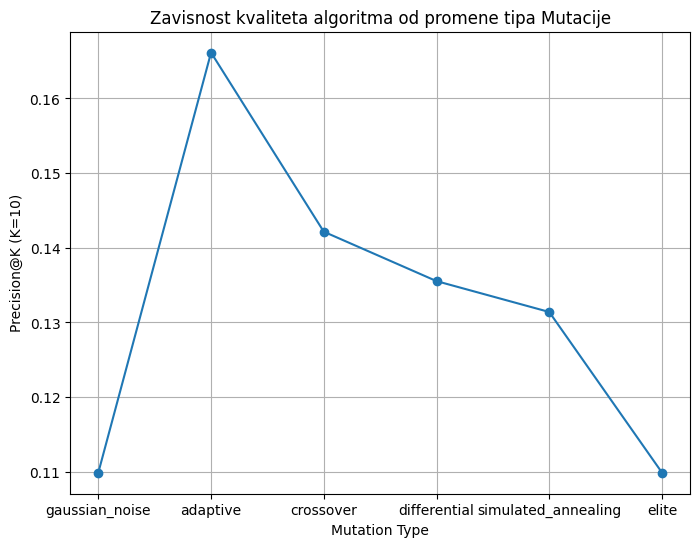

In [347]:
#--------------------------------------------------------------------------- EKSPERIMENT TRI
# Nisam mogao da napravim funkciju koja ce da izvuce rezultate pa sam manuelno testirao za svaki tip mutacije i izvukao rezultate

# precision_k_values = [0.10991735537190084, 0.16611570247933888, 0.14214876033057855, 0.13553719008264464, 0.13140495867768595, 0.10991735537190084]

# mutation_types = ["gaussian_noise", "adaptive", "crossover", "differential", "simulated_annealing", "elite"]
# plot_results(mutation_types, precision_k_values, "Zavisnost kvaliteta algoritma od promene tipa Mutacije", "Mutation Type")

Columns in the DataFrame: Index(['userId', 'movieId', 'ratings'], dtype='object')
Columns in the DataFrame: Index(['userId', 'movieId', 'ratings'], dtype='object')
Columns in the DataFrame: Index(['userId', 'movieId', 'ratings'], dtype='object')
Columns in the DataFrame: Index(['userId', 'movieId', 'ratings'], dtype='object')
Columns in the DataFrame: Index(['userId', 'movieId', 'ratings'], dtype='object')


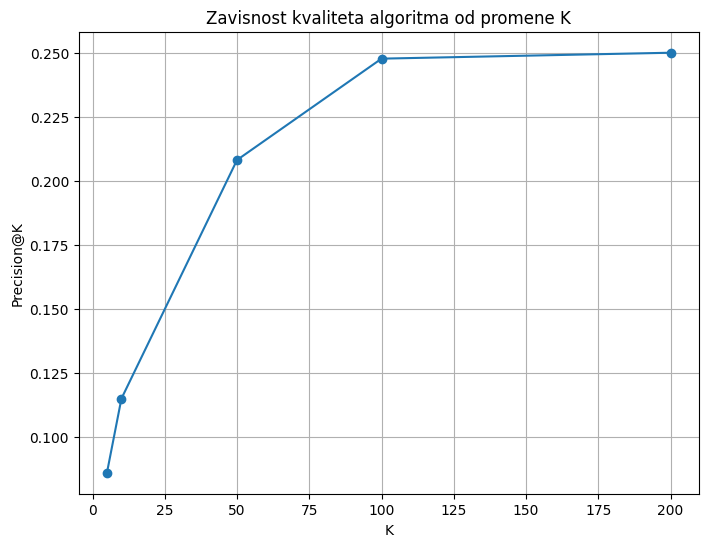

In [349]:
#---------------------------------------------------------- Eksperiment Cetiri
# def plot_results(x_values, y_values, title, xlabel):
#     plt.figure(figsize=(8, 6))
#     plt.plot(x_values, y_values, marker='o')
#     plt.title(title)
#     plt.xlabel(xlabel)
#     plt.ylabel('Precision@K')
#     plt.grid(True)
#     plt.show()
    
# k_val = [5, 10, 50, 100, 200]
    
# def evaluate_with_hyperparams(train_data, test_data, k, num_generations, mutation_rate):
#     recommendations = ais_recommender_system(train_data, num_generations=num_generations, mutation_rate=mutation_rate)
#     return evaluate_precision_at_k(test_data, train_data, k)

# precision_k_values = []
# for k in k_val:
# # Main function to tie everything together
#     if __name__ == "__main__":
#         # Load and split the data
#         data = load_movielens_data()
#         train_data, test_data = train_test_split(data, test_size=0.2, random_state=42)
#         average_precision_k = evaluate_with_hyperparams(train_data, test_data, k, num_generations= 10, mutation_rate=0.1)
#         precision_k_values.append(average_precision_k)
        
# plot_results(k_val, precision_k_values, "Zavisnost kvaliteta algoritma od promene K", "K")